In [27]:
import pandas as pd
# noinspection PyUnresolvedReferences
import tensorflow.keras as tk
# noinspection PyUnresolvedReferences
import tensorflow.keras.layers as l
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
# noinspection PyUnresolvedReferences
from tensorflow.keras.backend import clear_session
# noinspection PyUnresolvedReferences
from tensorflow.keras.models import clone_model
# noinspection PyUnresolvedReferences
from tensorflow.keras.utils import to_categorical

In [2]:
from utils import sub_percentage_of, plot_accuracy_and_loss, plot_categorical_distribution_with_percentage

In [3]:
import os

working_locally = not os.path.exists('/kaggle/working') and not os.path.exists('/content')

In [4]:
if working_locally:
    train_path = "mitbih_train.csv"
    test_path = "mitbih_test.csv"
else:
    train_path = "/kaggle/input/heartbeat/mitbih_train.csv"
    test_path = "/kaggle/input/heartbeat/mitbih_test.csv"

train_df = pd.read_csv(train_path, header=None)
test_df = pd.read_csv(test_path, header=None)

test_df.index = test_df.index + train_df.shape[0]

all_data = pd.concat([train_df, test_df])

all_data.rename(columns={187: 'class'}, inplace=True)

In [5]:
all_data

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,class
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109441,0.928736,0.871264,0.804598,0.742529,0.650575,0.535632,0.394253,0.250575,0.140230,0.102299,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
109442,0.802691,0.692078,0.587444,0.446936,0.318386,0.189836,0.118087,0.077728,0.112108,0.152466,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
109443,1.000000,0.967359,0.620178,0.347181,0.139466,0.089021,0.103858,0.100890,0.106825,0.100890,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
109444,0.984127,0.567460,0.607143,0.583333,0.607143,0.575397,0.575397,0.488095,0.392857,0.238095,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0


# Basic EDA

In [6]:
all_data.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,class
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
all_data['class'].value_counts()

0.0    90589
4.0     8039
2.0     7236
1.0     2779
3.0      803
Name: class, dtype: int64

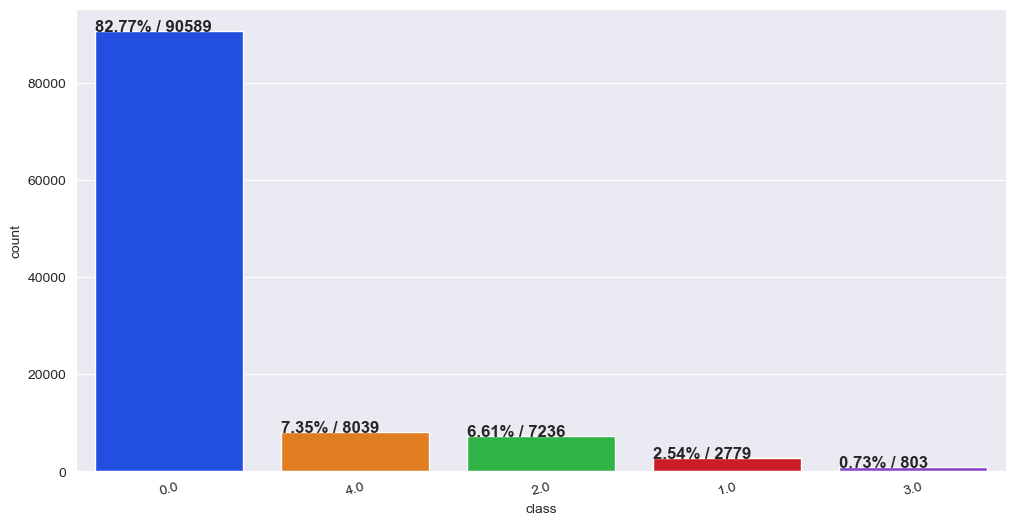

In [8]:
plot_categorical_distribution_with_percentage(all_data, 'class')

In [9]:
train_final = all_data[all_data.index < train_df.shape[0]]
test_final = all_data[all_data.index >= train_df.shape[0]]

In [10]:
train_final.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,class
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
test_final.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,class
87554,1.000000,0.758264,0.111570,0.000000,0.080579,0.078512,0.066116,0.049587,0.047521,0.035124,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
87555,0.908425,0.783883,0.531136,0.362637,0.366300,0.344322,0.333333,0.307692,0.296703,0.300366,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
87556,0.730088,0.212389,0.000000,0.119469,0.101770,0.101770,0.110619,0.123894,0.115044,0.132743,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
87557,1.000000,0.910417,0.681250,0.472917,0.229167,0.068750,0.000000,0.004167,0.014583,0.054167,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
87558,0.570470,0.399329,0.238255,0.147651,0.000000,0.003356,0.040268,0.080537,0.070470,0.090604,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
train_final.shape

(87554, 188)

In [13]:
test_final.shape

(21892, 188)

# Models

In [14]:
class_names = ["Normal", "Artial Premature", "Premature ventricular contraction", "Fusion of ventricular and normal",
               "Fusion of paced and normal"]
number_of_features = 187

# Training stage

In [15]:
from sklearn.model_selection import train_test_split

X = train_final.iloc[:, :-1].values
y = train_final.iloc[:, -1].values

y = to_categorical(y, num_classes=len(class_names))

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)
X_test = test_final.iloc[:, :-1].values
y_test = test_final.iloc[:, -1].values
y_test = to_categorical(y_test, num_classes=len(class_names))

In [16]:
if working_locally:
    X_train, y_train = sub_percentage_of(X_train, y_train, 0.05)
    X_valid, y_valid = sub_percentage_of(X_valid, y_valid, 0.05)
    X_test, y_test = sub_percentage_of(X_test, y_test, 0.05)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(70043, 187) (70043, 5)
(21892, 187) (21892, 5)


In [16]:
def build_model():
    model = tk.Sequential([
        l.Conv1D(32, kernel_size=5, strides=2, activation="relu", input_shape=(187, 1)),
        l.BatchNormalization(),
        l.Conv1D(64, kernel_size=5, strides=2, activation="relu"),
        l.BatchNormalization(),
        l.Conv1D(128, kernel_size=3, strides=2, activation="relu"),
        l.BatchNormalization(),
        l.Bidirectional(l.LSTM(64, return_sequences=True)),
        l.Bidirectional(l.LSTM(128)),
        l.Dropout(0.2),
        l.Dense(len(class_names), activation="softmax")
    ])
    optimizer = tk.optimizers.SGD(learning_rate=1e-2, clipnorm=1.)
    model.compile(loss="categorical_crossentropy",
                  optimizer=optimizer,
                  metrics=["accuracy"])
    return model

In [ ]:
model = build_model()
early_stopping = tk.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train,
                    epochs=100,
                    validation_data=(X_valid, y_valid),
                    callbacks=[early_stopping])

Epoch 1/100
2189/2189 [==============================] - 54s 19ms/step - loss: 0.3544 - accuracy: 0.9021 - val_loss: 0.2082 - val_accuracy: 0.9497
Epoch 2/100
2189/2189 [==============================] - 40s 18ms/step - loss: 0.1870 - accuracy: 0.9510 - val_loss: 0.1749 - val_accuracy: 0.9507
Epoch 3/100
2189/2189 [==============================] - 39s 18ms/step - loss: 0.1517 - accuracy: 0.9578 - val_loss: 0.1424 - val_accuracy: 0.9569
Epoch 4/100
2189/2189 [==============================] - 37s 17ms/step - loss: 0.1322 - accuracy: 0.9625 - val_loss: 0.1270 - val_accuracy: 0.9632
Epoch 5/100
2189/2189 [==============================] - 37s 17ms/step - loss: 0.1211 - accuracy: 0.9654 - val_loss: 0.1209 - val_accuracy: 0.9677
Epoch 6/100
2189/2189 [==============================] - 38s 17ms/step - loss: 0.1126 - accuracy: 0.9684 - val_loss: 0.1485 - val_accuracy: 0.9581
Epoch 7/100
2189/2189 [==============================] - 37s 17ms/step - loss: 0.1066 - accuracy: 0.9704 - val_loss: 0

In [ ]:
plot_accuracy_and_loss(history)

In [ ]:
model.evaluate(X_test, y_test)

In [ ]:
model.save('model_bi_lstm.h5')

In [23]:
model = tk.models.load_model('../models/model_bi_lstm.h5', compile=False)
optimizer = tk.optimizers.SGD(learning_rate=1e-2, clipnorm=1.)
model.compile(loss="categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])
model.evaluate(X_test, y_test)

685/685 [==============================] - 17s 17ms/step - loss: 0.0756 - accuracy: 0.9802


[0.07558475434780121, 0.9802210927009583]

In [26]:
test_labels = y_test.argmax(axis=1)
prediction_labels = model.predict(X_test).argmax(axis=1)
cm = confusion_matrix(test_labels, prediction_labels)
cm

685/685 [==============================] - 12s 17ms/step


array([[18016,    48,    25,    13,    16],
       [  179,   367,     8,     1,     1],
       [   56,     6,  1369,    13,     4],
       [   24,     0,    18,   120,     0],
       [   16,     1,     4,     0,  1587]], dtype=int64)

In [28]:
print(classification_report(test_labels, prediction_labels, target_names=class_names))

                                   precision    recall  f1-score   support

                           Normal       0.98      0.99      0.99     18118
                 Artial Premature       0.87      0.66      0.75       556
Premature ventricular contraction       0.96      0.95      0.95      1448
 Fusion of ventricular and normal       0.82      0.74      0.78       162
       Fusion of paced and normal       0.99      0.99      0.99      1608

                         accuracy                           0.98     21892
                        macro avg       0.92      0.87      0.89     21892
                     weighted avg       0.98      0.98      0.98     21892



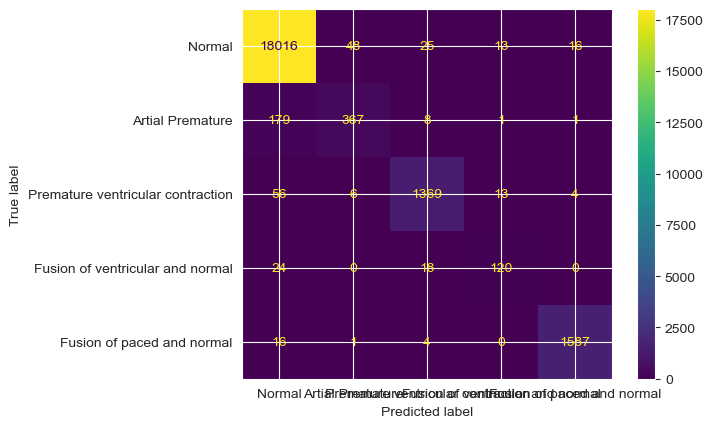

In [29]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot();

### retraining using a balanced dataset

In [30]:
from sklearn.utils import resample


def get_balanced_data():
    class0_df = train_df[train_df[187] == 0]
    class1_df = train_df[train_df[187] == 1]
    class2_df = train_df[train_df[187] == 2]
    class3_df = train_df[train_df[187] == 3]
    class4_df = train_df[train_df[187] == 4]

    class1_up_sampled = resample(class1_df, n_samples=20000, replace=True, random_state=1)
    class2_up_sampled = resample(class2_df, n_samples=20000, replace=True, random_state=1)
    class3_up_sampled = resample(class3_df, n_samples=20000, replace=True, random_state=1)
    class4_up_sampled = resample(class4_df, n_samples=20000, replace=True, random_state=1)

    class0_down_sampled = class0_df.sample(n=20000, random_state=0)

    return pd.concat([class0_down_sampled,
                      class1_up_sampled,
                      class2_up_sampled,
                      class3_up_sampled,
                      class4_up_sampled])

In [31]:
balanced_train_df = get_balanced_data()

In [32]:
X = balanced_train_df.iloc[:, :-1].values
y = balanced_train_df.iloc[:, -1].values

y = to_categorical(y, num_classes=len(class_names))

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
if working_locally:
    X_train, y_train = sub_percentage_of(X_train, y_train, 0.05)
    X_valid, y_valid = sub_percentage_of(X_valid, y_valid, 0.05)

print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)

In [ ]:
model = build_model()
early_stopping = tk.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train,
                    epochs=100,
                    validation_data=(X_valid, y_valid),
                    callbacks=[early_stopping])

In [ ]:
plot_accuracy_and_loss(history)

In [ ]:
model.evaluate(X_test, y_test)

In [ ]:
model.save('model_bi_lstm_trained_on_balanced_data.h5')

In [33]:
model = tk.models.load_model('../models/model_bi_lstm_trained_on_balanced_data.h5', compile=False)
optimizer = tk.optimizers.SGD(learning_rate=1e-2, clipnorm=1.)
model.compile(loss="categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])
model.evaluate(X_test, y_test)

685/685 [==============================] - 15s 16ms/step - loss: 0.1415 - accuracy: 0.9674


[0.14146755635738373, 0.9673853516578674]

In [34]:
prediction_labels = model.predict(X_test).argmax(axis=1)
cm = confusion_matrix(test_labels, prediction_labels)
cm

685/685 [==============================] - 13s 16ms/step


array([[17610,   264,   161,    46,    37],
       [   89,   450,    10,     5,     2],
       [   20,     2,  1399,    20,     7],
       [   10,     0,    16,   135,     1],
       [   12,     5,     7,     0,  1584]], dtype=int64)

In [35]:
print(classification_report(test_labels, prediction_labels, target_names=class_names))

                                   precision    recall  f1-score   support

                           Normal       0.99      0.97      0.98     18118
                 Artial Premature       0.62      0.81      0.70       556
Premature ventricular contraction       0.88      0.97      0.92      1448
 Fusion of ventricular and normal       0.66      0.83      0.73       162
       Fusion of paced and normal       0.97      0.99      0.98      1608

                         accuracy                           0.97     21892
                        macro avg       0.82      0.91      0.86     21892
                     weighted avg       0.97      0.97      0.97     21892



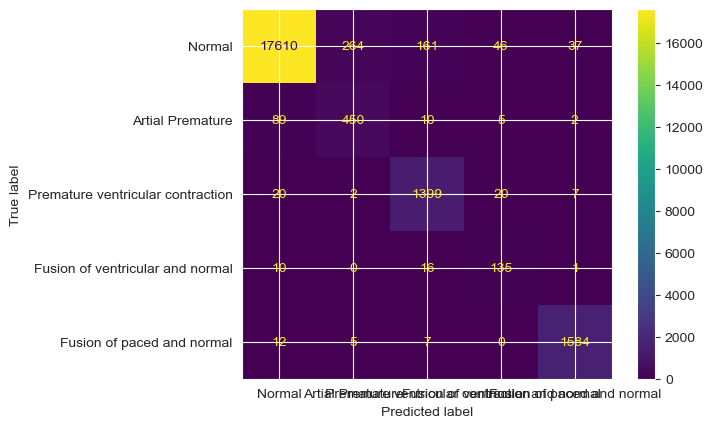

In [36]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot();